# Load and Preprocess Image

This notebook shows how to load and preprocess an image dataset in three ways
1. First, we'll use high-level Keras preprocessing utilities (such as ``tf.keras.utils.image_dataset_from_directory``) and layers (such as ``tf.keras.layers.Rescalling``) to read a directory of images on disk.
2. Next, we'll write our own input pipeline from scratcg using ``tf.data``
3. Finally, we will download dataset fron the large catalog availabel in TensorFlow Datasets

## Setup

In [4]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)

2.10.1


### Download the flowers dataset

This notebook uses a dataset of several thousand photos of flowers. The flowers dataset contains a five sub-directories, one per class:

In [18]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

There are 3670 total images:

In [19]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Each directory contains images of that type of flower. Here are some roses:

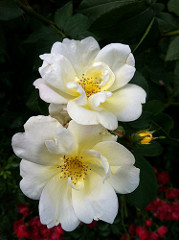

In [20]:
roses=list(data_dir.glob("roses/*"))
PIL.Image.open(str(roses[0]))

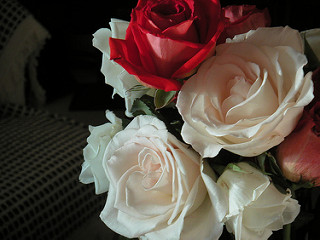

In [22]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## Load data using a Keras utility
Let's load these images off disk using the helpful ``tf.keras.utils.image_dataset_from_dicretory`` utility.

### Create a dataset
Define some parameters for the loader:

In [25]:
batch_size=32
img_height=180
img_width=180

It's good practice to use a validation split when developing our model. We'll use 80% of the images for training and 20% for validation

In [26]:
train_ds=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [27]:
val_ds=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


We can find the class names in the ``class_name`` attribute on these datasets

In [80]:
class_names=train_ds.class_names
print(class_names)

AttributeError: 'PrefetchDataset' object has no attribute 'class_names'

### Visualize the data
Here are the first nine images from the training dataset

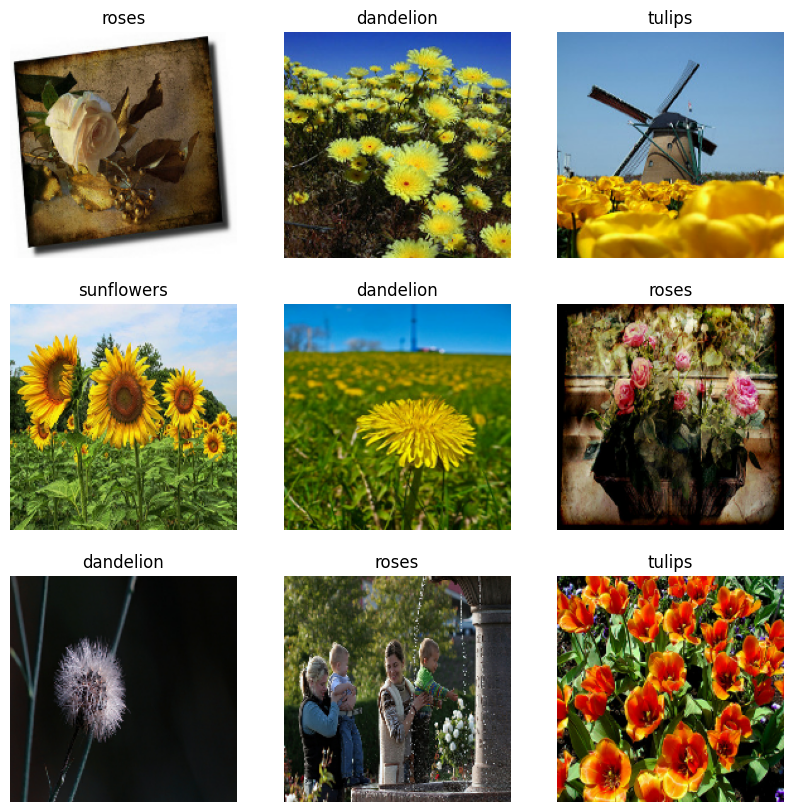

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

We can train a model using these datasets by passing them to ``model.fit``. We can also manually iterate over the dataset and retrieve batches of images:

In [33]:
for image_batch,labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [34]:
for image_batch,labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


The ``image_batch`` is a tensor of the shape ``(32,180,180,3)``. This is a batch of 32 images of shape ``180x180x3`` (the last dimension refers to color channels RGB). The ``label_batch`` is a tensorflow of the shape ``(32,),`` these are corresponding labels to the 32 images.
</br>
</br>
We can call ``.numpy()`` on either of these tensors to convert them to a ``numpy.ndarray``

### Standardize the data
The RGB channel values are in the ``[0,255]``. This is not ideal for a neural network; in general we should seel to make our input values small.
</br>
</br>
Here, we will standardize values to be in the ``[0,1]`` range by using ``tf.keras.layers.Rescalling``

In [35]:
normalization_layer=tf.keras.layers.Rescaling(1./255)

These are two ways to use this layer. We can apply it to the dataset by calling ``Dataset.map``:

In [36]:
normalized_ds=train_ds.map(lambda x,y:(normalization_layer(x),y))
image_batch,labels_batch=next(iter(normalized_ds))
first_image=image_batch[0]
print(np.min(first_image),np.max(first_image))

0.0 1.0


Or, we can include the layer inside our model definition to simplify deployment. We will use the second approach here.

### Configure the dataset for performance
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods we should use when loading data:
1. ``Dataset.cache`` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training our model. If our dataset is too large to fit into memory, we can also use this method to create a performant on-disk cache.
1. ``Dataset.prefetch`` overlaps data preprocessing and model execution while training

In [38]:
AUTOTUNE=tf.data.AUTOTUNE

train_ds=train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model
The ``Sequential`` model consists of three convolution blocks (``tf.keras.layers.Con2D``) with a max pooling layer(``tf.keras.layers.MaxPooling2D``) in each of them. There's a fully-connected layer (``tf.keras.layers.Dense``) with 128 units on top of it that is activated by a ReLU activation function (``'relu'``). This model has not been tuned in any way -  the goal is to show the mechanics using the datasets we just created.

In [39]:
num_classes=5

model=tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32,3,activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

Choose the ``tf.keras.optimizers.Adam`` optimizer and ``tf.keras.losses.SparseCategoricalCrossentropy`` loss function. To view training and validation accuracy for each training epoch, pass the ``metrics`` argument to ``Model.compile``

In [40]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [41]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 27s 50ms/step - loss: 1.3408 - accuracy: 0.4217 - val_loss: 1.0609 - val_accuracy: 0.5586
Epoch 2/3
92/92 [==============================] - 4s 39ms/step - loss: 1.0351 - accuracy: 0.5845 - val_loss: 0.9882 - val_accuracy: 0.5899
Epoch 3/3
92/92 [==============================] - 4s 40ms/step - loss: 0.8974 - accuracy: 0.6546 - val_loss: 0.8911 - val_accuracy: 0.6512


We may notice the validation accuracy is low compared to the training accuracy, indicating our model is overfitting. 

## Using tf.data for finer control
The above Keras preprocessing utility - ``tf.keras.utils.image_dataset_from_directory`` is a convenient way to create a ``tf.data.Dataset`` from a directory of images
</br>
</br>
For finer grain control, we can write our own input pipeline using ``tf.data``. This section shows how to do just that, beginning with the file paths from the TGZ file we downloaded earlier.

In [42]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds=list_ds.shuffle(image_count,reshuffle_each_iteration=False)

In [44]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\nighthawks\\.keras\\datasets\\flower_photos\\daisy\\3661613900_b15ca1d35d_m.jpg'
b'C:\\Users\\nighthawks\\.keras\\datasets\\flower_photos\\daisy\\3337643329_accc9b5426.jpg'
b'C:\\Users\\nighthawks\\.keras\\datasets\\flower_photos\\roses\\4505921907_21c8002fde.jpg'
b'C:\\Users\\nighthawks\\.keras\\datasets\\flower_photos\\tulips\\13562266594_69b807f90c.jpg'
b'C:\\Users\\nighthawks\\.keras\\datasets\\flower_photos\\dandelion\\13942846777_5571a6b0a1_n.jpg'


The tree structure of the files can be used to compile a ``class_names`` list

In [48]:
class_names=np.array(sorted([item.name for item in data_dir.glob("*") if item.name !="LICENSE.txt"]))
print(class_names)

['LICENSE.txt' 'daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Split the dataset into training and validation sets:

In [49]:
val_size=int(image_count*0.2)
train_ds=list_ds.skip(val_size)
val_ds=list_ds.take(val_size)

We can print the length of each dataset as follows:

In [50]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Write a function that converts a file path to an ``(img, label)`` pair:

In [55]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [52]:
def decode_img(img):
    img=tf.io.decode_jpeg(img,channels=3)
    return tf.image.resize(img,[img_height,img_width])

In [53]:
def prerprocess_path(file_path):
    label=get_label(file_path)
    img=tf.io.read_file(file_path)
    img=decode_img(img)
    return img,label

Use ``Dataset.map`` to create a dataset of ``image, label`` pairs:

In [68]:
train_ds=train_ds.map(prerprocess_path,num_parallel_calls=AUTOTUNE)
val_ds=val_ds.map(prerprocess_path,num_parallel_calls=AUTOTUNE)

In [69]:
for image,label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  5


### Configure dataset for performace
To train a model with this dataset we will want the data:
- To be well shuffled
- To be batched
- Batches to be available as soon as possible

These features can be added using the ``tf.data`` API

In [70]:
def configure_for_performance(ds):
    ds=ds.cache()
    ds=ds.shuffle(buffer_size=1000)
    ds=ds.batch(batch_size)
    ds=ds.prefetch(buffer_size=AUTOTUNE)
    return ds
train_ds=configure_for_performance(train_ds)
val_ds=configure_for_performance(val_ds)

### Visualize the data
We can visualize this dataset similarly to the one we created previously

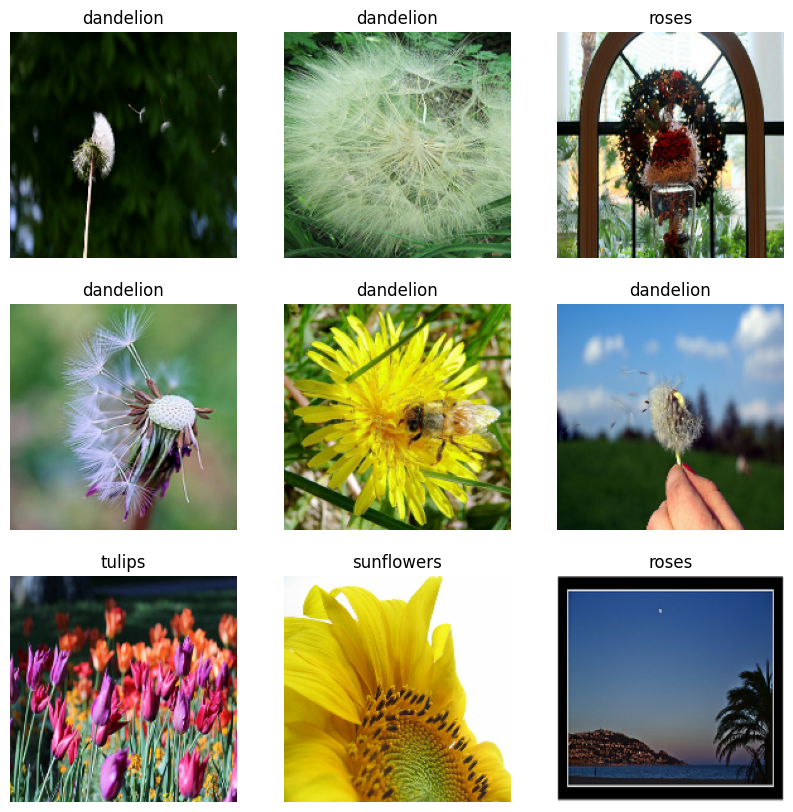

In [71]:
image_batch,label_batch=next(iter(train_ds))


plt.figure(figsize=(10,10))
for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    label=label_batch[i]
    plt.title(class_names[label])
    plt.axis('off')

### Continue training the model
We have now manually built a similar ``tf.data.Dataset`` to the one created by ``tf.keras.utils.image_dataset_from_directory`` above. We can continue training the model with it. As before, we will train for just a few epochs to keep th running time short.

In [73]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 5s 44ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/3
92/92 [==============================] - 3s 38ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/3
92/92 [==============================] - 4s 38ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00


## Using TensorFlow Datasets
So far, we has focused on loading data off disk. We can also find a dataset to use by exploring the large catalog of easy-to-download datasets at TensorFlow Datasets
</br>
</br>
Download the Flowers dataset using TensorFlow Datasets

In [74]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)


Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 49.77 url/s]


Dataset tf_flowers downloaded and prepared to C:\Users\nighthawks\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


The flowers dataset have five classes:

In [76]:
num_classes=metadata.features['label'].num_classes
print(num_classes)

5


Retriece an image from the dataset

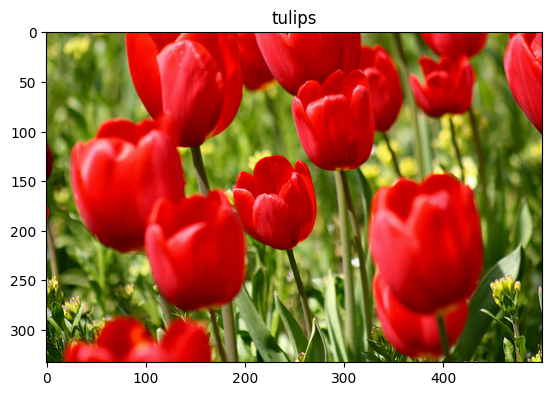

In [78]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))